# Imports

In [1]:
import xarray as xr
import h5py
import numpy as np
import pylab as plt
import cartopy
import cartopy.crs as ccrs
import h5py 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.patches as mpatches

# Functions

In [2]:
def cartopy_ax_2(crs, ax):
    """
    Returns a Cartopy axis with features such as land, ocean, coastline, and borders added to it.
    The axis is also configured with gridlines and formatted tick labels.
    Args:
    crs (cartopy.crs.CRS): The coordinate system of the axis.
    ax (matplotlib.axes.Axes): The axis to be modified.
    
    Returns:
    matplotlib.axes.Axes: The modified axis.
    """
    ax.add_feature(cartopy.feature.OCEAN, zorder=2)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.2)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
    return ax

In [3]:
def extract_coordinates(flag_array, lons, lats):
    """
    Extracts the minimum and maximum longitude and latitude values from the flag array.

    Parameters:
    flag_array (numpy.ndarray): 2D array where the region of interest is marked with 1s.
    lons (numpy.ndarray): 2D array of longitudes corresponding to the flag_array.
    lats (numpy.ndarray): 2D array of latitudes corresponding to the flag_array.

    Returns:
    tuple: (min_lon, max_lon, min_lat, max_lat)
    """
    # Find indices where the flag_array is 1
    y_indices, x_indices = np.where(flag_array == 1)

    # Extract the corresponding longitude and latitude values
    selected_lons = lons[y_indices, x_indices]
    selected_lats = lats[y_indices, x_indices]

    # Calculate min and max values
    min_lon = np.min(selected_lons)
    max_lon = np.max(selected_lons)
    min_lat = np.min(selected_lats)
    max_lat = np.max(selected_lats)

    return min_lon, max_lon, min_lat, max_lat


In [4]:
# Load the 'oranges' colormap
import matplotlib.colors as mcolors

oranges = plt.cm.get_cmap('Oranges', 32)  # 256 is the number of colors

# Extract the colormap array
oranges_colors = oranges(np.arange(32))

# Set the first color to white
oranges_colors[0] = (1, 1, 1, 1)  # RGBA value for white

oranges_cmap = LinearSegmentedColormap.from_list('custom_linear_cmap', oranges_colors)
# Create a new colormap with the modified colors

C:\Users\faisa\AppData\Local\Temp\ipykernel_948\3386696798.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  oranges = plt.cm.get_cmap('Oranges', 32)  # 256 is the number of colors


# Desert Areas

In [51]:
bodele_flag = np.zeros((148, 357))
bodele_flag[96:120,100:129]=1 


sistan_flag = np.zeros((148, 357))
sistan_flag[43:61,280:307]=1

shamal_flag = np.zeros((148, 357))
shamal_flag[41:62,228:238]=1

north_algeria_flag = np.zeros((148, 357))
north_algeria_flag[30:38,42:54]=1

nubian_flag = np.zeros((148, 357))
nubian_flag[94:110,170:193]=1

talak_flag = np.zeros((148, 357))
talak_flag[79:102,49:78]=1

syria_flag = np.zeros((148, 357))
syria_flag[24:33,208:219]=1

libya_flag = np.zeros((148, 357))
libya_flag[41:47,131:141]=1

# Dust sources

In [6]:
hf = h5py.File("sea_flag_seviri.h5")
sea_flag = hf["sea_flag"][:] 
sea_flag[sea_flag>500]=0

In [7]:
dss= []
for yr in [2018,2019,2020,2021,2022]:
    ds = xr.open_dataset("plume_properties_"+str(yr)+".nc")
    dss.append(ds)
ds_all = xr.concat(dss , dim="plume_id")

In [8]:
ds_all['source_contribution']= ds_all.source*ds_all.contribution
source_contribution_all = ds_all.source_contribution.sum(dim="plume_id").values
source_contribution_all[sea_flag]=0
source_contribution_all= source_contribution_all.astype(float)
source_contribution_fraction = source_contribution_all / np.sum(source_contribution_all)

In [18]:
bounds  = (-11.625, 77.375, 5.625, 42.375)
crs = ccrs.PlateCarree()

In [10]:
ds_all = ds_all.set_index(plume_id='start_time')
ds_all = ds_all.rename({'plume_id': 'start_time'})

In [11]:
djf_dust_c = ds_all.sel(start_time=ds_all.start_time.dt.season == "DJF").source_contribution.sum(dim= "start_time").values.astype(float)
mam_dust_c = ds_all.sel(start_time=ds_all.start_time.dt.season == "MAM").source_contribution.sum(dim= "start_time").values.astype(float)
jja_dust_c = ds_all.sel(start_time=ds_all.start_time.dt.season == "JJA").source_contribution.sum(dim= "start_time").values.astype(float)
son_dust_c = ds_all.sel(start_time=ds_all.start_time.dt.season == "SON").source_contribution.sum(dim= "start_time").values.astype(float)

djf_dust_c [sea_flag]=0
mam_dust_c [sea_flag]=0
jja_dust_c [sea_flag]=0
son_dust_c [sea_flag]=0

In [12]:
sum_all_seasons= np.nansum([np.nansum(djf_dust_c ), np.nansum(mam_dust_c),  np.nansum(jja_dust_c),  np.nansum(son_dust_c)])
djf_dust_c = djf_dust_c / sum_all_seasons *100 
mam_dust_c = mam_dust_c / sum_all_seasons *100
jja_dust_c = jja_dust_c / sum_all_seasons *100
son_dust_c = son_dust_c / sum_all_seasons *100

In [13]:
djf_dust_s = ds_all.sel(start_time=ds_all.start_time.dt.season == "DJF").source.sum(dim= "start_time").values.astype(float)/5
mam_dust_s =ds_all.sel(start_time=ds_all.start_time.dt.season == "MAM").source.sum(dim= "start_time").values.astype(float)/5
jja_dust_s =ds_all.sel(start_time=ds_all.start_time.dt.season == "JJA").source.sum(dim= "start_time").values.astype(float)/5
son_dust_s =ds_all.sel(start_time=ds_all.start_time.dt.season == "SON").source.sum(dim= "start_time").values.astype(float)/5

all_dust_s = ds_all.source.sum(dim= "start_time").values.astype(float)/5

djf_dust_s [sea_flag]=0
mam_dust_s [sea_flag]=0
jja_dust_s [sea_flag]=0
son_dust_s [sea_flag]=0

all_dust_s [sea_flag]=0

In [14]:
source_contribution_percentage= source_contribution_fraction *100

In [77]:
print(np.nanmin(djf_dust_c),np.nanmax(mam_dust_c),np.nanmax(jja_dust_c),np.nanmax(son_dust_c))
c_ = "Grays"
max_val = 0.025
min_val=0

0.0 0.02451995431727972 0.034180777109633256 0.009596265531633733


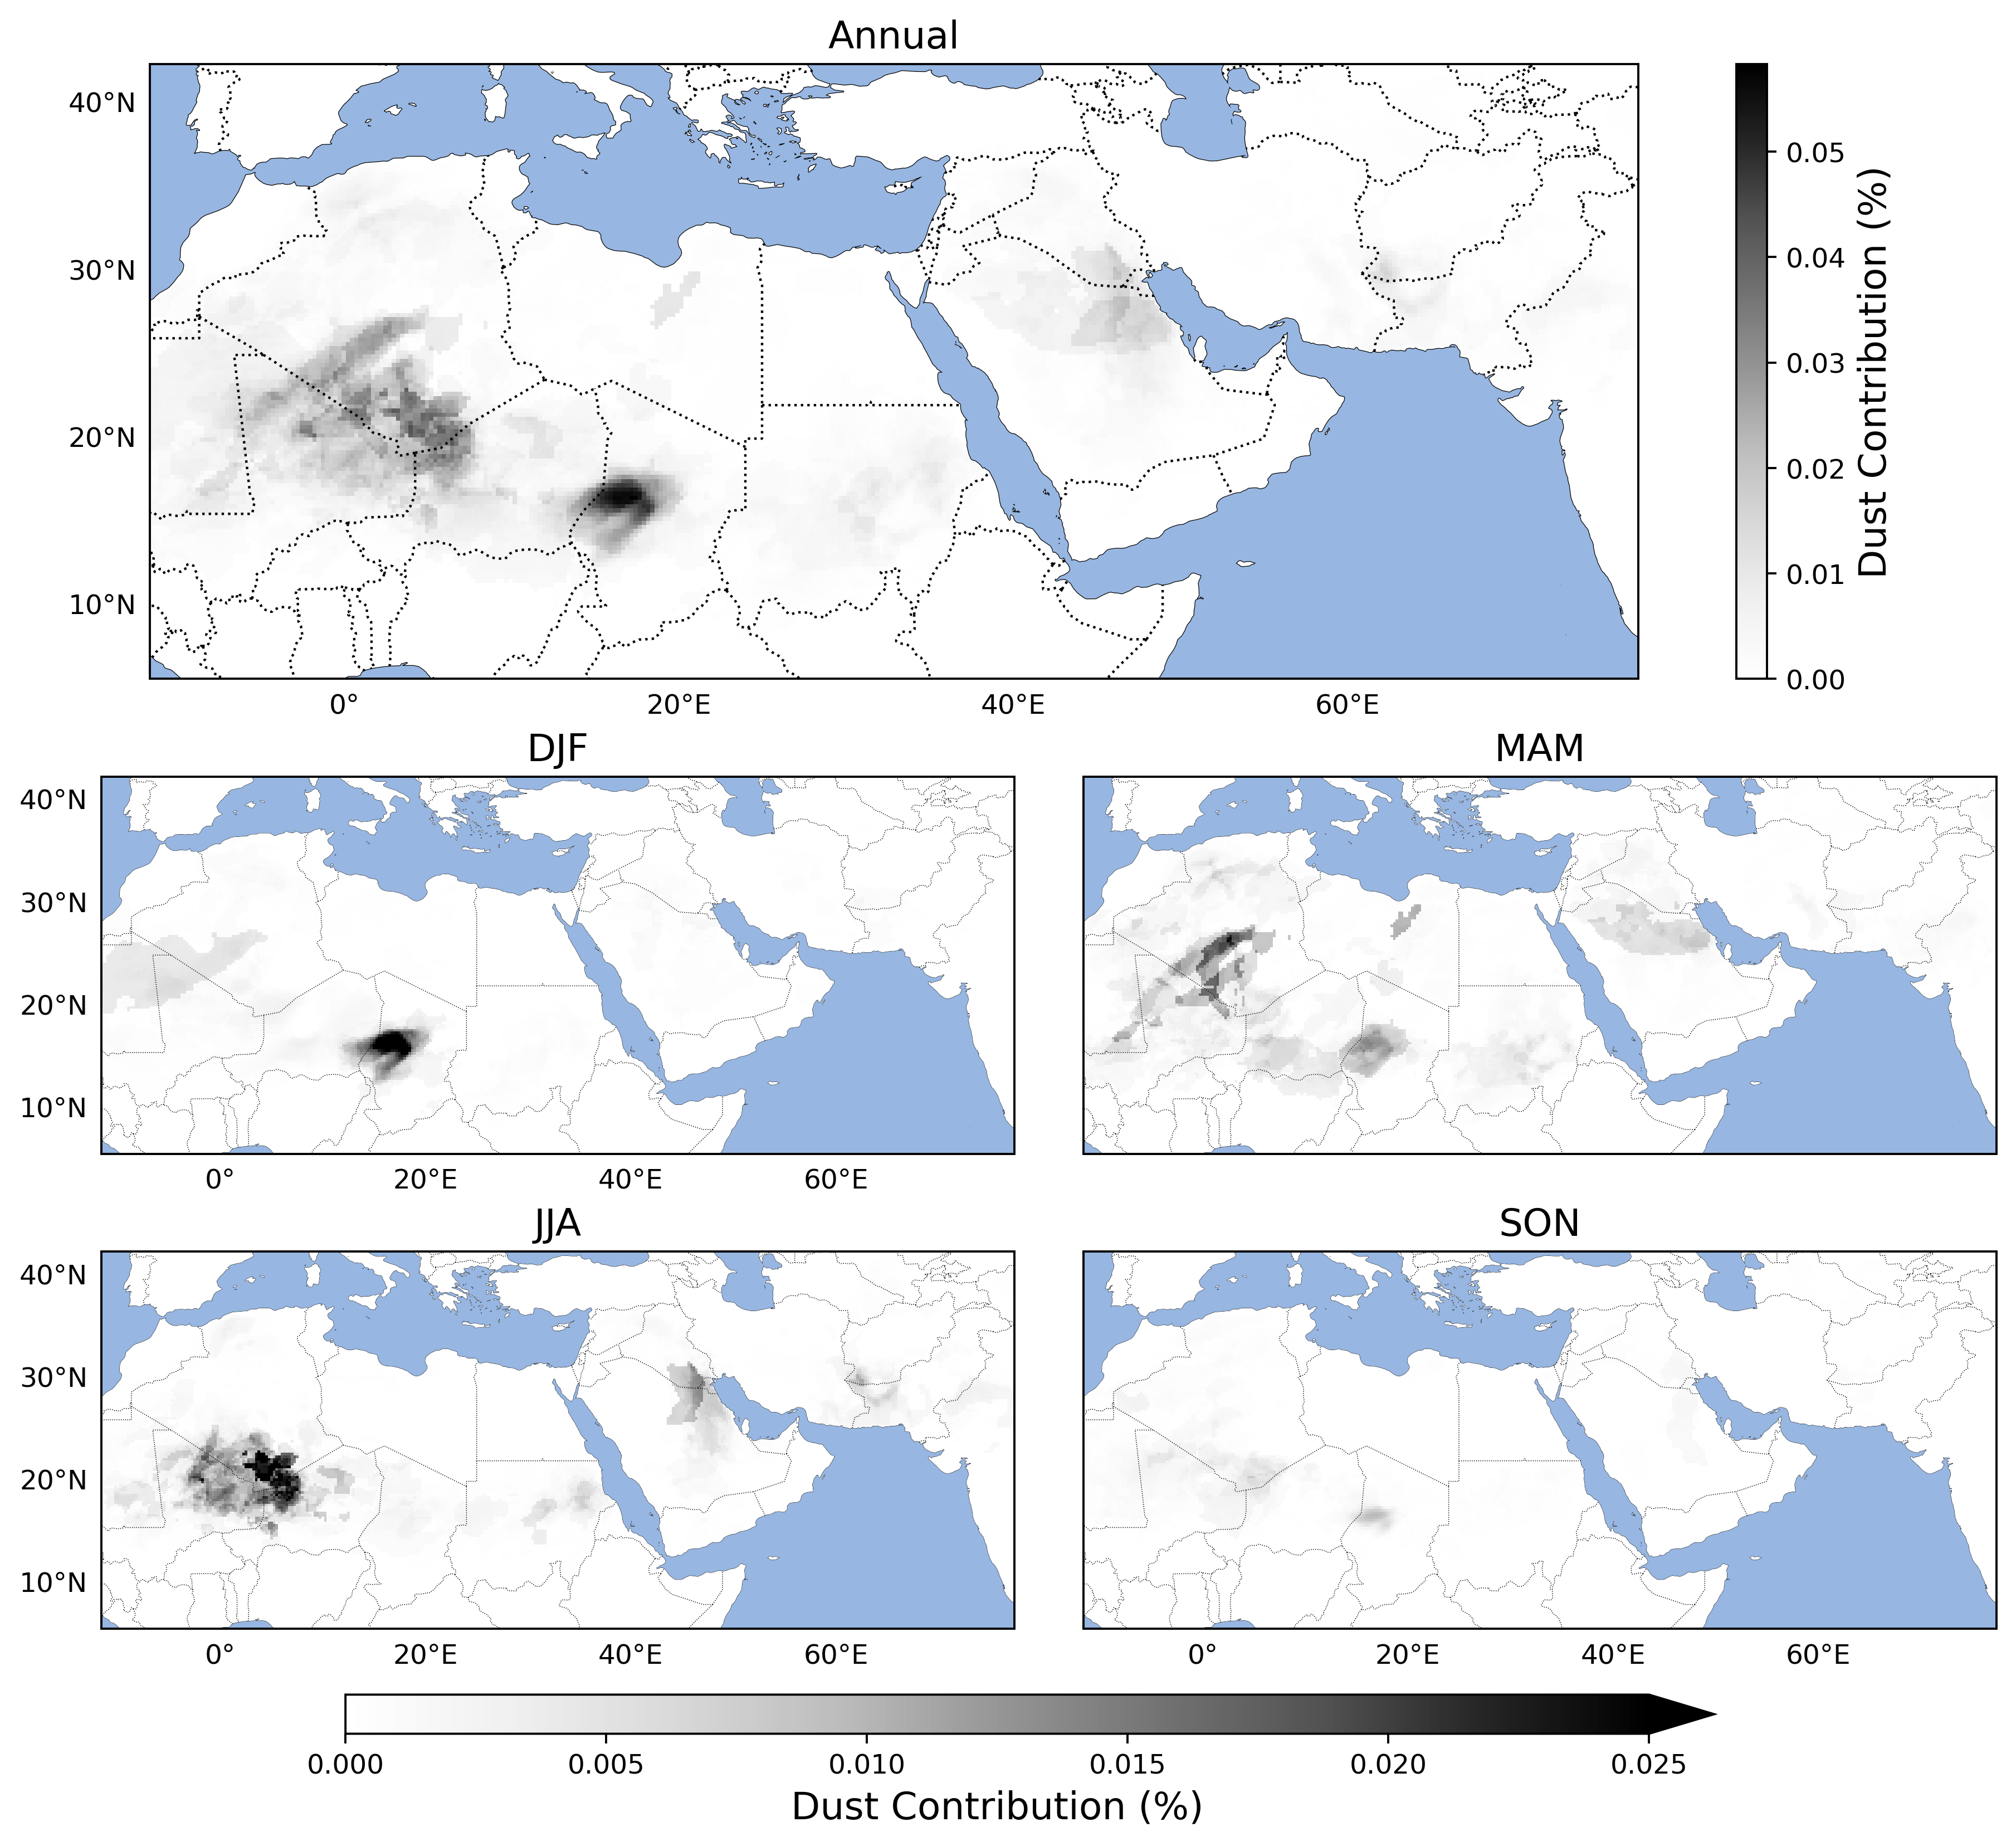

In [78]:
fig = plt.figure(figsize=(13, 12) , dpi=350)

gs = gridspec.GridSpec(8, 2)

ax0 = plt.subplot(gs[0:3, :], projection=crs )
ax0.set_extent(bounds, crs)
ax0.add_feature(cartopy.feature.OCEAN, zorder=2)
ax0.add_feature(cartopy.feature.COASTLINE, linewidth=0.5)
ax0.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.9)
im0 = ax0.imshow(source_contribution_percentage, transform=crs, extent=bounds, cmap=c_)




gl = ax0.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40])

ax0.set_title("Annual", size=14 )
cbar0 = fig.colorbar(im0, ax=ax0 , extend="neither" , aspect=20) 
cbar0.set_label('Dust Contribution (%)', size=14)
#cbar0.formatter.set_powerlimits((0, 0))
cbar0.update_ticks()
#cbar0.ax.tick_params(labelsize=16)
#cbar0.ax.yaxis.offsetText.set_fontsize(16)

ax1 = plt.subplot(gs[3:5, 0], projection=crs)
ax1 = cartopy_ax_2(crs, ax1)
ax1.set_extent(bounds, crs)
ax1.imshow(djf_dust_c, transform=crs, extent=bounds, cmap=c_, vmax=max_val , vmin=min_val)
ax1.set_title("DJF" , size= 14)
gl = ax1.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xlabels_bottom = False 
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40])

ax2 = plt.subplot(gs[3:5, 1], projection=crs)
ax2 = cartopy_ax_2(crs, ax2)
ax2.set_extent(bounds, crs)
ax2.imshow(mam_dust_c, transform=crs, extent=bounds, cmap=c_, vmax=max_val , vmin=min_val)
ax2.set_title("MAM", size= 14)

ax3 = plt.subplot(gs[5:7, 0], projection=crs)
ax3 = cartopy_ax_2(crs, ax3)
ax3.set_extent(bounds, crs)
ax3.set_title("JJA", size= 14)
m = ax3.imshow(jja_dust_c, transform=crs, extent=bounds, cmap=c_ , vmax=max_val , vmin=min_val)
gl = ax3.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40])

ax4 = plt.subplot(gs[5:7, 1], projection=crs)
ax4 = cartopy_ax_2(crs, ax4)
ax4.set_extent(bounds, crs)
ax4.set_title("SON", size= 14)
ax4.imshow(son_dust_c, transform=crs, extent=bounds, cmap=c_, vmax=max_val , vmin=min_val)
gl = ax4.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.left_labels = False 
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])

# Colorbar
cax = plt.subplot(gs[7:, :])
cax.set_aspect(0.00075)
cbar = plt.colorbar(m, cax=cax, orientation='horizontal', extend="max")
cbar.set_label('Dust Contribution (%)', size=14)

plt.subplots_adjust(hspace=0.7, wspace=0.0001)
cax.set_position([0.235, 0.15, 0.54, 0.05])

plt.savefig("D:/figs/sources_contribution.pdf" , bbox_inches="tight")
plt.show()


In [39]:
c_ = oranges_cmap
max_val = 20
min_val=0
cc= "black"
linw= 0.5

In [36]:
lats = ds_all.latitude.values
lons = ds_all.longitude.values

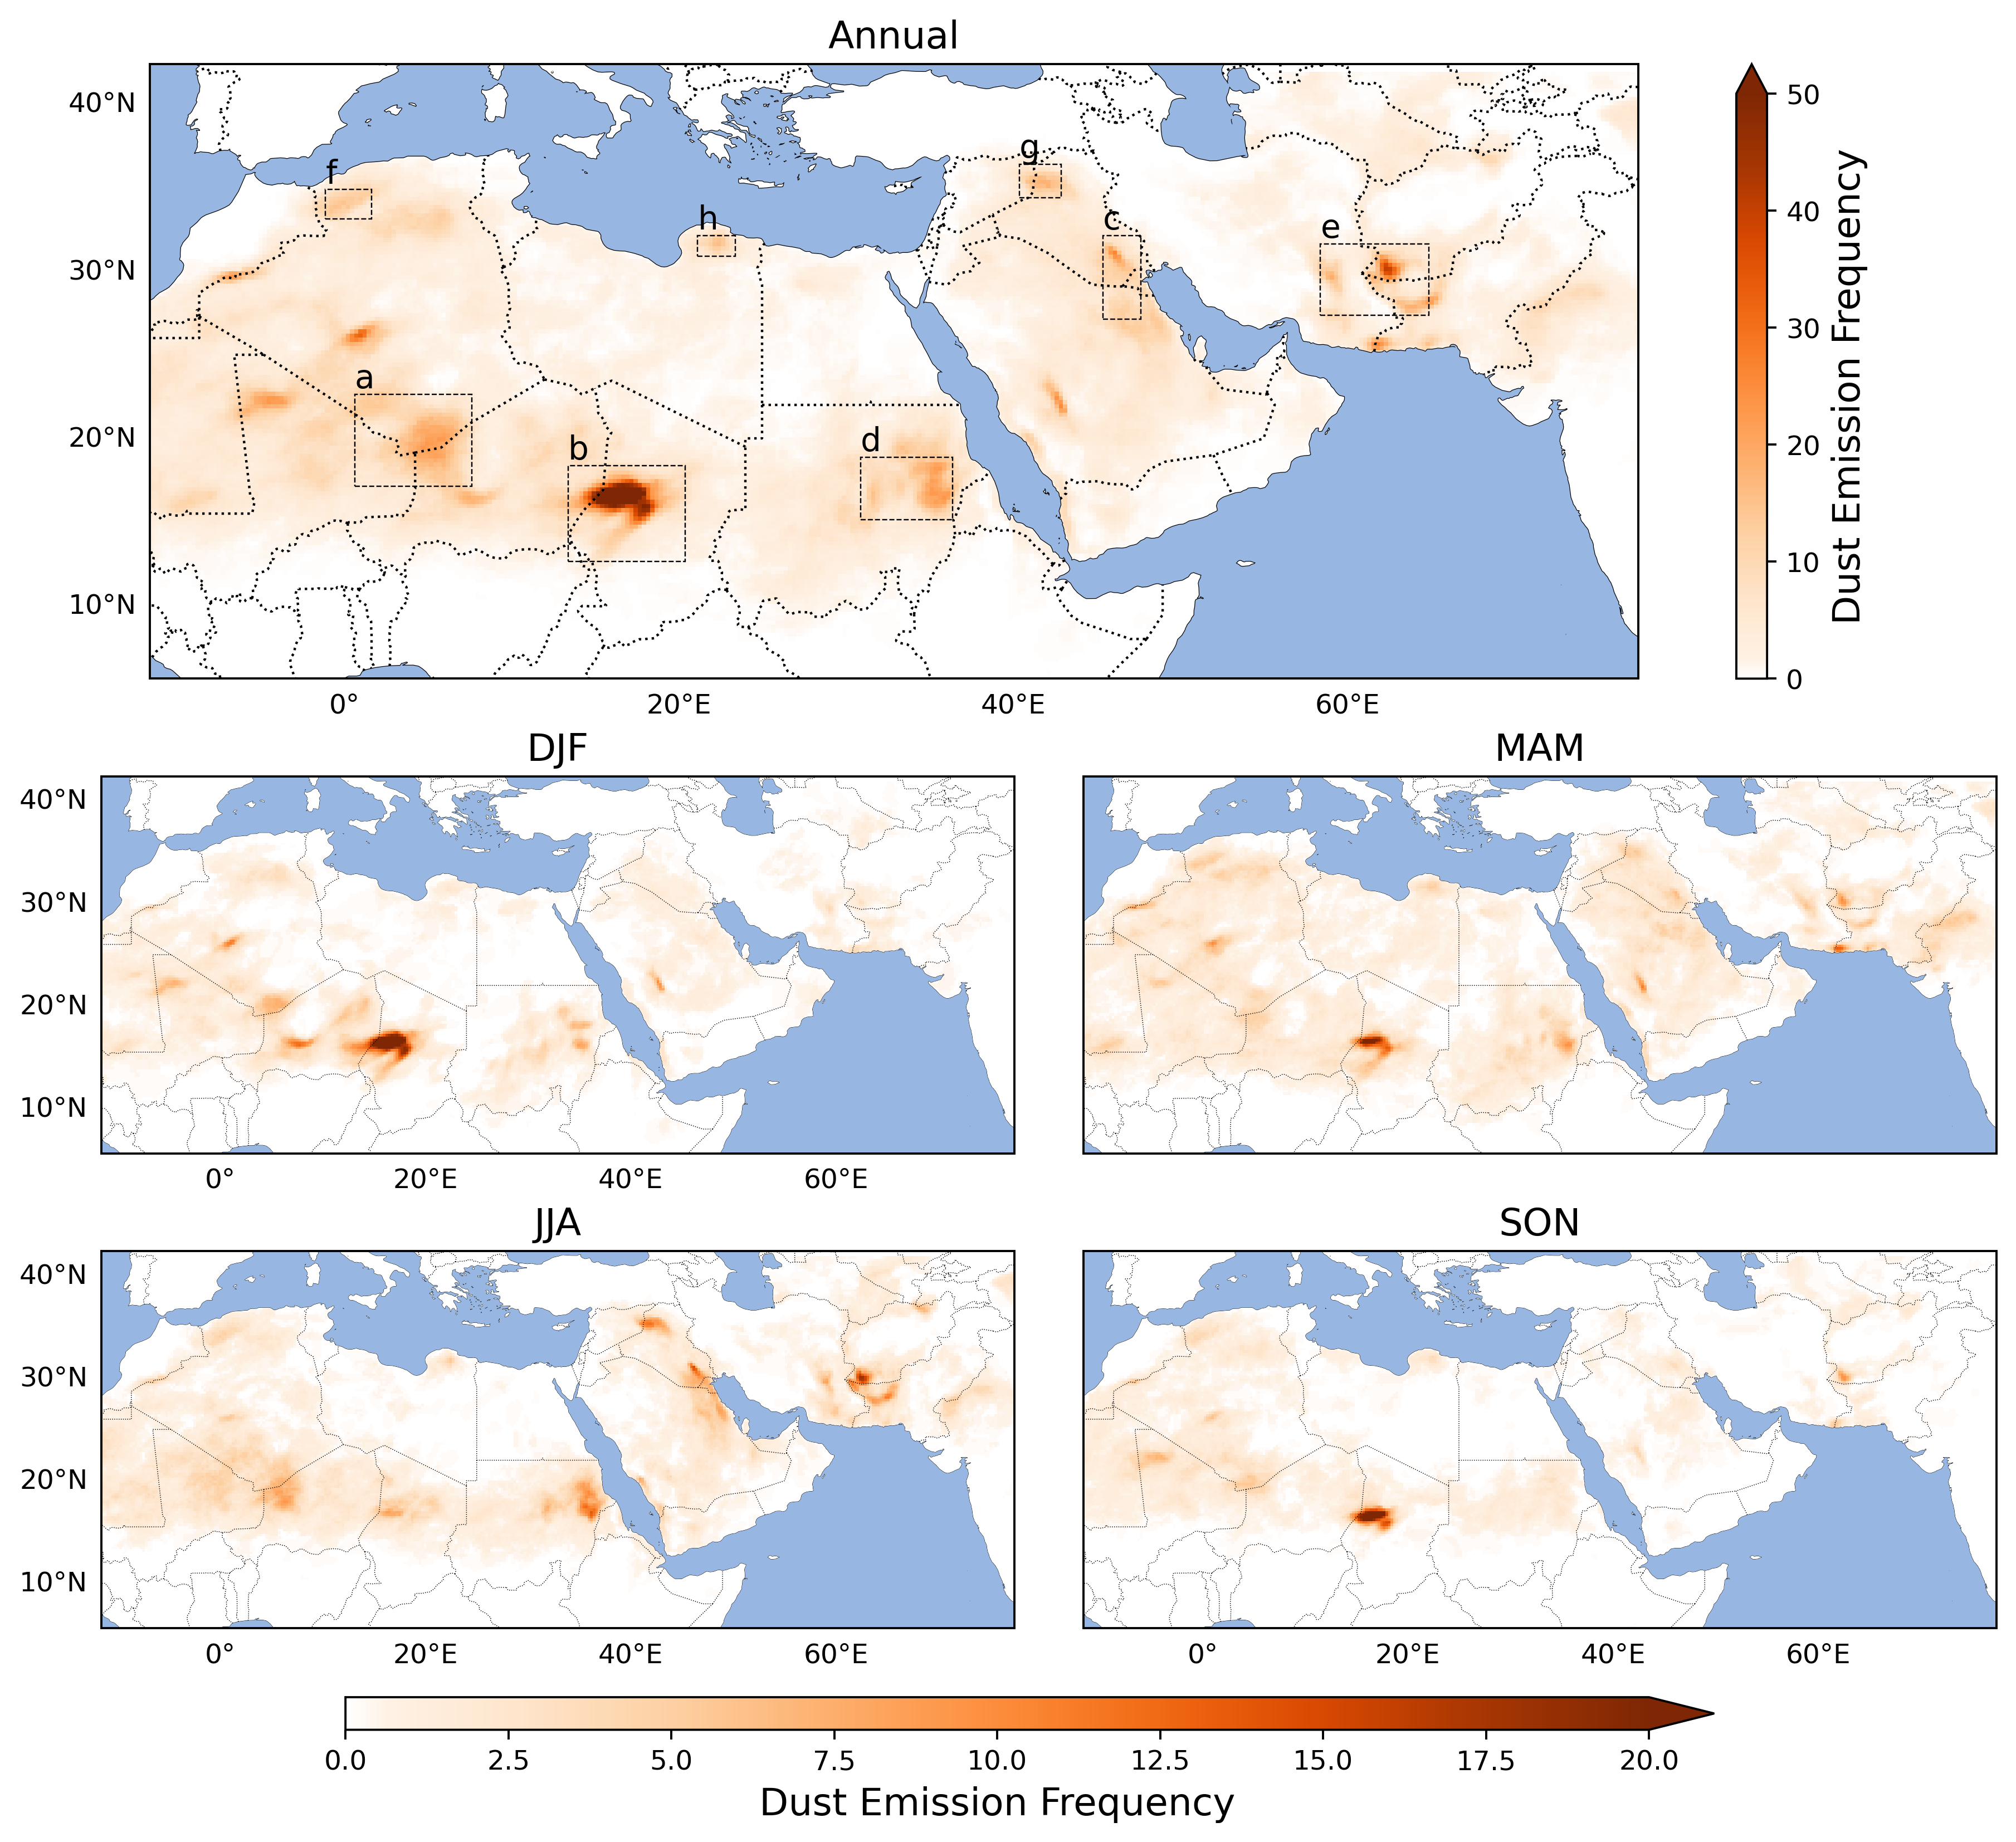

In [52]:
fig = plt.figure(figsize=(13, 12) , dpi=350)

gs = gridspec.GridSpec(8, 2)

ax0 = plt.subplot(gs[0:3, :], projection=crs )
ax0.set_extent(bounds, crs)
ax0.add_feature(cartopy.feature.OCEAN, zorder=2)
ax0.add_feature(cartopy.feature.COASTLINE, linewidth=0.5)
ax0.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.9)
im0 = ax0.imshow(all_dust_s, transform=crs, extent=bounds, cmap=c_ , vmax=50)


# Define labels for the rectangles
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# List of flags to loop through
flags = [talak_flag , bodele_flag, shamal_flag, nubian_flag , sistan_flag , north_algeria_flag ,syria_flag , libya_flag]

# Loop through each flag, create a rectangle, and add a label
for i, flag in enumerate(flags):
    min_lon, max_lon, min_lat, max_lat = extract_coordinates(flag, lons, lats)
    rect_width = max_lon - min_lon
    rect_height = max_lat - min_lat
    
    # Create and add a Rectangle patch
    rectangle = mpatches.Rectangle((min_lon, min_lat), rect_width, rect_height,
                                   transform=crs, edgecolor=cc, facecolor='none', lw=linw, linestyle="--")
    ax0.add_patch(rectangle)
    
    # Add a label above the rectangle
    ax0.text(min_lon, max_lat, labels[i], transform=crs, verticalalignment='bottom', horizontalalignment='left', fontsize=12, color='black')





gl = ax0.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40])

ax0.set_title("Annual", size=14 )
cbar0 = fig.colorbar(im0, ax=ax0 , extend="max" , aspect=20) 
cbar0.set_label('Dust Emission Frequency', size=14)
#cbar0.formatter.set_powerlimits((0, 0))
cbar0.update_ticks()
#cbar0.ax.tick_params(labelsize=16)
#cbar0.ax.yaxis.offsetText.set_fontsize(16)

ax1 = plt.subplot(gs[3:5, 0], projection=crs)
ax1 = cartopy_ax_2(crs, ax1)
ax1.set_extent(bounds, crs)
ax1.imshow(djf_dust_s, transform=crs, extent=bounds, cmap=c_, vmax=max_val , vmin=min_val)
ax1.set_title("DJF" , size= 14)
gl = ax1.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xlabels_bottom = False 
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40])

ax2 = plt.subplot(gs[3:5, 1], projection=crs)
ax2 = cartopy_ax_2(crs, ax2)
ax2.set_extent(bounds, crs)
ax2.imshow(mam_dust_s, transform=crs, extent=bounds, cmap=c_, vmax=max_val , vmin=min_val)
ax2.set_title("MAM", size= 14)

ax3 = plt.subplot(gs[5:7, 0], projection=crs)
ax3 = cartopy_ax_2(crs, ax3)
ax3.set_extent(bounds, crs)
ax3.set_title("JJA", size= 14)
m = ax3.imshow(jja_dust_s, transform=crs, extent=bounds, cmap=c_ , vmax=max_val , vmin=min_val)
gl = ax3.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40])

ax4 = plt.subplot(gs[5:7, 1], projection=crs)
ax4 = cartopy_ax_2(crs, ax4)
ax4.set_extent(bounds, crs)
ax4.set_title("SON", size= 14)
ax4.imshow(son_dust_s, transform=crs, extent=bounds, cmap=c_, vmax=max_val , vmin=min_val)
gl = ax4.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.left_labels = False 
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])

# Colorbar
cax = plt.subplot(gs[7:, :])
cax.set_aspect(0.5)
cbar = plt.colorbar(m, cax=cax, orientation='horizontal', extend="max")
cbar.set_label('Dust Emission Frequency', size=14)

plt.subplots_adjust(hspace=0.7, wspace=0.0001)
cax.set_position([0.235, 0.15, 0.54, 0.05])

plt.savefig("D:/figs/sources_frequency_with_boxes.pdf" , bbox_inches="tight")
plt.show()


# Contribution Bodele

In [53]:
np.sum(source_contribution_percentage)

100.0

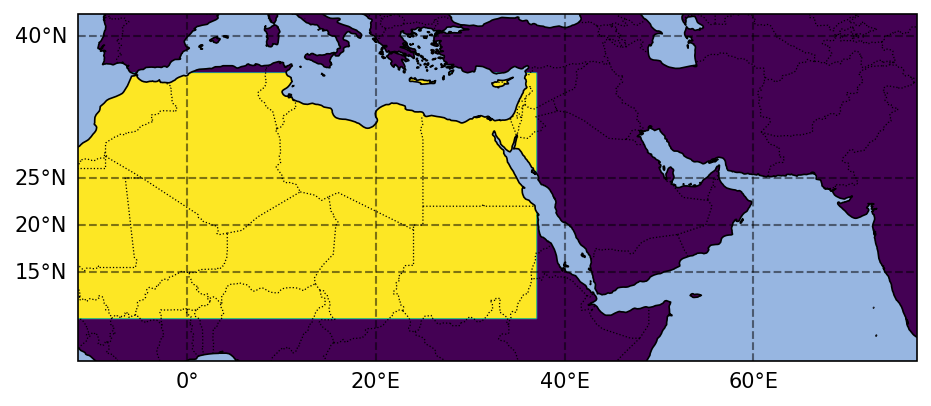

Sahara contribution :  82.34040103940035


In [54]:
y0,y1,x0,x1 = 25,130,0,195
sahara_flag = np.zeros((148, 357))
sahara_flag[y0:y1, x0:x1]=1
min_lon, max_lon, min_lat, max_lat = extract_coordinates(sahara_flag, lons, lats)
rect_width = max_lon - min_lon
rect_height = max_lat - min_lat

crs= ccrs.PlateCarree()
plt.figure(figsize=(9,3), dpi=150)
ax = plt.axes(projection=crs)
ax.add_feature(cartopy.feature.OCEAN, zorder=1)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.6)
ax.set_extent(bounds, crs)
img = plt.imshow(sahara_flag, transform=crs, extent=bounds)



gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0.5, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([15, 20, 25, 40])



# Define the rectangle's lower left corner and its width and height
# min_lon, max_lon, min_lat, max_lat = extract_coordinates(bodele_flag, lons, lats)
# rect_width = max_lon - min_lon
# rect_height = max_lat - min_lat

# Create a Rectangle patch
rectangle = mpatches.Rectangle((min_lon, min_lat), rect_width, rect_height,
                               transform=crs, 
                               edgecolor='gray', facecolor='none')

plt.show()



cropped_source_contribution = source_contribution_percentage[y0:y1,x0:x1]
print("Sahara contribution : ", np.sum(cropped_source_contribution))

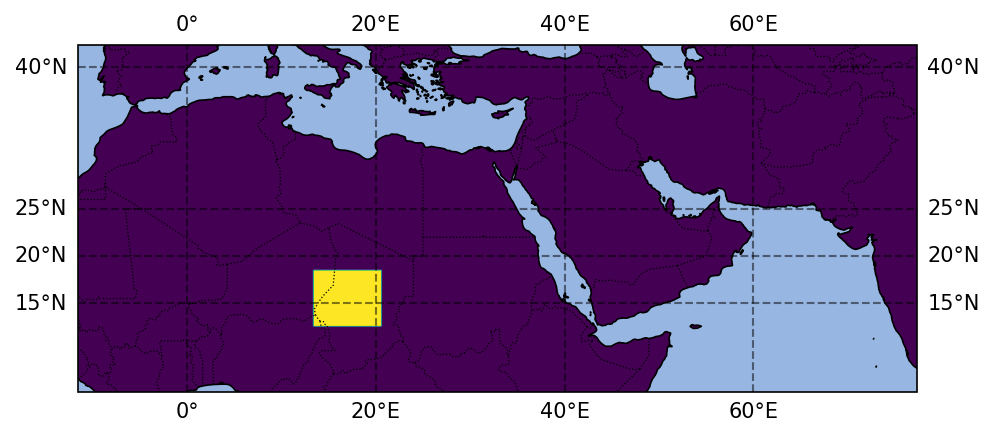

Bodele contribution :  12.740404282546335


In [55]:
y0,y1,x0,x1 = 96,120,100,129
min_lon, max_lon, min_lat, max_lat = extract_coordinates(bodele_flag, lons, lats)
rect_width = max_lon - min_lon
rect_height = max_lat - min_lat

crs= ccrs.PlateCarree()
plt.figure(figsize=(9,3), dpi=150)
ax = plt.axes(projection=crs)
ax.add_feature(cartopy.feature.OCEAN, zorder=1)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.6)
ax.set_extent(bounds, crs)
img = plt.imshow(bodele_flag, transform=crs, extent=bounds)



gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0.5, linestyle="--")
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([15, 20, 25, 40])


# Create a Rectangle patch
rectangle = mpatches.Rectangle((min_lon, min_lat), rect_width, rect_height,
                               transform=crs, 
                               edgecolor='gray', facecolor='none')

plt.show()



cropped_source_contribution = source_contribution_percentage[y0:y1,x0:x1]
print("Bodele contribution : ", np.sum(cropped_source_contribution))

In [56]:
12.74/82.34 # Bodele/ Sahara

0.15472431382074325

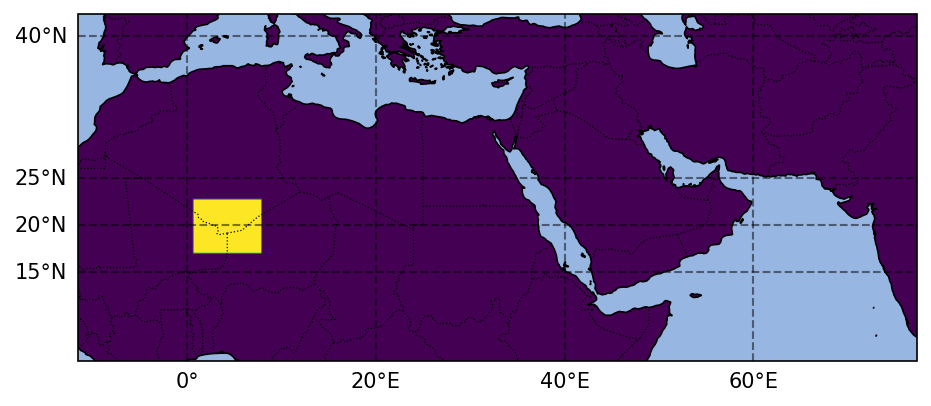

Talak contribution :  15.6619173989164


In [57]:
y0,y1,x0,x1 = 79,102,49,78
min_lon, max_lon, min_lat, max_lat = extract_coordinates(talak_flag, lons, lats)
rect_width = max_lon - min_lon
rect_height = max_lat - min_lat

crs= ccrs.PlateCarree()
plt.figure(figsize=(9,3), dpi=150)
ax = plt.axes(projection=crs)
ax.add_feature(cartopy.feature.OCEAN, zorder=1)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.6)
ax.set_extent(bounds, crs)
img = plt.imshow(talak_flag, transform=crs, extent=bounds)



gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0.5, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([0, 20,40,60]) #])40, 60, 80, -140, -120])
gl.ylocator = mticker.FixedLocator([15, 20, 25, 40])


# Create a Rectangle patch
rectangle = mpatches.Rectangle((min_lon, min_lat), rect_width, rect_height,
                               transform=crs, 
                               edgecolor='gray', facecolor='none')

plt.show()



cropped_source_contribution = source_contribution_percentage[y0:y1,x0:x1]
print("Talak contribution : ", np.sum(cropped_source_contribution))

In [58]:
15.66/82.34 # Talak/ Sahara

0.19018702939033277

# Plume Extents

In [59]:
dss= []
for yr in [2018,2019,2020,2021,2022]:
    ds = xr.open_dataset("plume_properties_"+str(yr)+".nc")
    dss.append(ds)
ds_all = xr.concat(dss , dim="plume_id")

In [60]:
print("bodele contribution : ", np.sum(source_contribution_percentage[bodele_flag==1]))
print("sistan contribution : ", np.sum(source_contribution_percentage[sistan_flag==1]))
print("shamal contribution : ", np.sum(source_contribution_percentage[shamal_flag==1]))
print("algeria contribution : ", np.sum(source_contribution_percentage[north_algeria_flag==1]))
print("nubian contribution : ", np.sum(source_contribution_percentage[nubian_flag==1]))
print("talak contribution : ", np.sum(source_contribution_percentage[talak_flag==1]))
print("syria contribution : ", np.sum(source_contribution_percentage[syria_flag==1]))
print("libya contribution : ", np.sum(source_contribution_percentage[libya_flag==1]))

bodele contribution :  12.740404282546335
sistan contribution :  1.7789277817897555
shamal contribution :  2.4651081707758675
algeria contribution :  0.528102318399319
nubian contribution :  1.8175701770624901
talak contribution :  15.6619173989164
syria contribution :  0.2629566633063865
libya contribution :  0.05703992343266459


In [61]:
def get_extent(ds_all,flag):
    """
    Description:
    ------------
    This function calculates the extent of coverage based on a flag mask (for the desert).
    It filters the dataset to include only those plumes where the flag intersects with the 
    identified source and then computes the sum of the 'coverage' variable for the filtered entries.


    Parameters:
    -----------
    ds_all : xarray.Dataset
        Dataset containing storm information, including 'source' and 'coverage' variables.
    flag : array-like
        Mask indicating the desert or area of interest, with dimensions ["lat", "lon"].


    Returns:
    --------
    extent : numpy.ndarray
        The sum of the 'coverage' variable for the filtered dataset entries.
    """
    mask_da = xr.DataArray(flag, dims=["lat", "lon"], coords={"lat": ds.lat, "lon": ds.lon})
    broadcasted_mask = xr.broadcast(mask_da, ds_all['source'])[0]
    masked_source = ds_all['source'].where(mask_da, other=False)
    times_with_intersection = masked_source.any(dim=['lat', 'lon'])
    storms_dates = times_with_intersection.plume_id.values[times_with_intersection.values]
    filtered_ds = ds_all.where(times_with_intersection, drop=True)
    extent = filtered_ds.coverage.sum(dim="plume_id").values
    return extent

In [67]:
# Divided by 5 to get the average per year
bodele_coverage = get_extent(ds_all,bodele_flag) /5
sistan_coverage = get_extent(ds_all,sistan_flag)/5
shamal_coverage = get_extent(ds_all,shamal_flag)/5
north_algeria_coverage = get_extent(ds_all,north_algeria_flag)/5
nubian_coverage = get_extent(ds_all,nubian_flag)/5
talak_coverage = get_extent(ds_all,talak_flag)/5
syria_coverage = get_extent(ds_all,syria_flag)/5
libya_coverage = get_extent(ds_all,libya_flag)/5

In [63]:

# Define the colormap
# Define the colormap using hex codes
cmap = mcolors.ListedColormap(['#FFFFFF',  # White
                               '#E6E6FA',  # Lavender
                               '#BA55D3',  # Medium Orchid
                               '#4B0082']) # Dark Purple# Define the boundaries for each color
boundaries = [0,5, 150, 300, 450]
# Create a normalize object the describes the limits of each color
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)
boundaries = [0,1, 5, 10, 15]
# Create a normalize object the describes the limits of each color
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

In [64]:
# Replace values in coverage with np.nan where they are less than or equal to 1 and sea_flag is 1,
# so that these values are transparent in the colormap

In [69]:
# Printing the ratio of each map to ensure that width to height ratio is consistent = 1.33
bodele_extent = np.array([-11.4,30,5.5,36.63])
bodele_coverage = np.where((bodele_coverage < 1) & (sea_flag == 1), np.nan, bodele_coverage)
print(  ( bodele_extent[1]-bodele_extent[0]) ,  (bodele_extent[3]-bodele_extent[2])  , ( bodele_extent[1]-bodele_extent[0]) / (bodele_extent[3]-bodele_extent[2]))
#
north_algeria_extent = np.array([-12,30,10.43,42])
print( ( north_algeria_extent[1]-north_algeria_extent[0]) ,  (north_algeria_extent[3]-north_algeria_extent[2])  , ( north_algeria_extent[1]-north_algeria_extent[0]) / (north_algeria_extent[3]-north_algeria_extent[2]))
north_algeria_coverage = np.where((north_algeria_coverage < 1) & (sea_flag == 1), np.nan, north_algeria_coverage)


shamal_extent = np.array([20.38,66,7.7,42])
print( ( shamal_extent[1]-shamal_extent[0]) ,  (shamal_extent[3]-shamal_extent[2])  , ( shamal_extent[1]-shamal_extent[0]) / (shamal_extent[3]-shamal_extent[2]))
shamal_coverage = np.where((shamal_coverage < 1) & (sea_flag == 1), np.nan, shamal_coverage)

sitan_extent = np.array([45,78,15.2,40])
print( ( sitan_extent[1]-sitan_extent[0]) ,  (sitan_extent[3]-sitan_extent[2])  , ( sitan_extent[1]-sitan_extent[0]) / (sitan_extent[3]-sitan_extent[2]))
sistan_coverage = np.where((sistan_coverage <= 1) & (sea_flag == 1), np.nan, sistan_coverage)

nubian_extent = np.array([11,50,2.94,32.26])
print((nubian_extent[1]-nubian_extent[0]) ,  (nubian_extent[3]-nubian_extent[2])  , ( nubian_extent[1]-nubian_extent[0]) / (nubian_extent[3]-nubian_extent[2]))
nubian_coverage = np.where((nubian_coverage <= 1) & (sea_flag == 1), np.nan, nubian_coverage)

talak_extent = np.array([-11.5,35.45,6.7,42])
print( ( talak_extent[1]-talak_extent[0]) ,  (talak_extent[3]-talak_extent[2])  , ( talak_extent[1]-talak_extent[0]) / (talak_extent[3]-talak_extent[2]))
talak_coverage = np.where((talak_coverage <= 1) & (sea_flag == 1), np.nan, talak_coverage)

syria_extent = np.array([32,60,20.95,42])
print( ( syria_extent[1]-syria_extent[0]) ,  (syria_extent[3]-syria_extent[2])  , ( syria_extent[1]-syria_extent[0]) / (syria_extent[3]-syria_extent[2]))
syria_coverage = np.where((syria_coverage <= 1) & (sea_flag == 1), np.nan, syria_coverage)

libya_extent = np.array([10.72,35,19.75,38])
print( ( libya_extent[1]-libya_extent[0]) ,  (libya_extent[3]-libya_extent[2])  , ( libya_extent[1]-libya_extent[0]) / (libya_extent[3]-libya_extent[2]))
libya_coverage = np.where((libya_coverage <= 1) & (sea_flag == 1), np.nan, libya_coverage)


41.4 31.130000000000003 1.3299068422743332
42.0 31.57 1.3303769401330376
45.620000000000005 34.3 1.3300291545189507
33.0 24.8 1.3306451612903225
39.0 29.319999999999997 1.3301500682128242
46.95 35.3 1.3300283286118981
28.0 21.05 1.330166270783848
24.28 18.25 1.3304109589041095


In [70]:
cc = "yellow"
linw=0.4

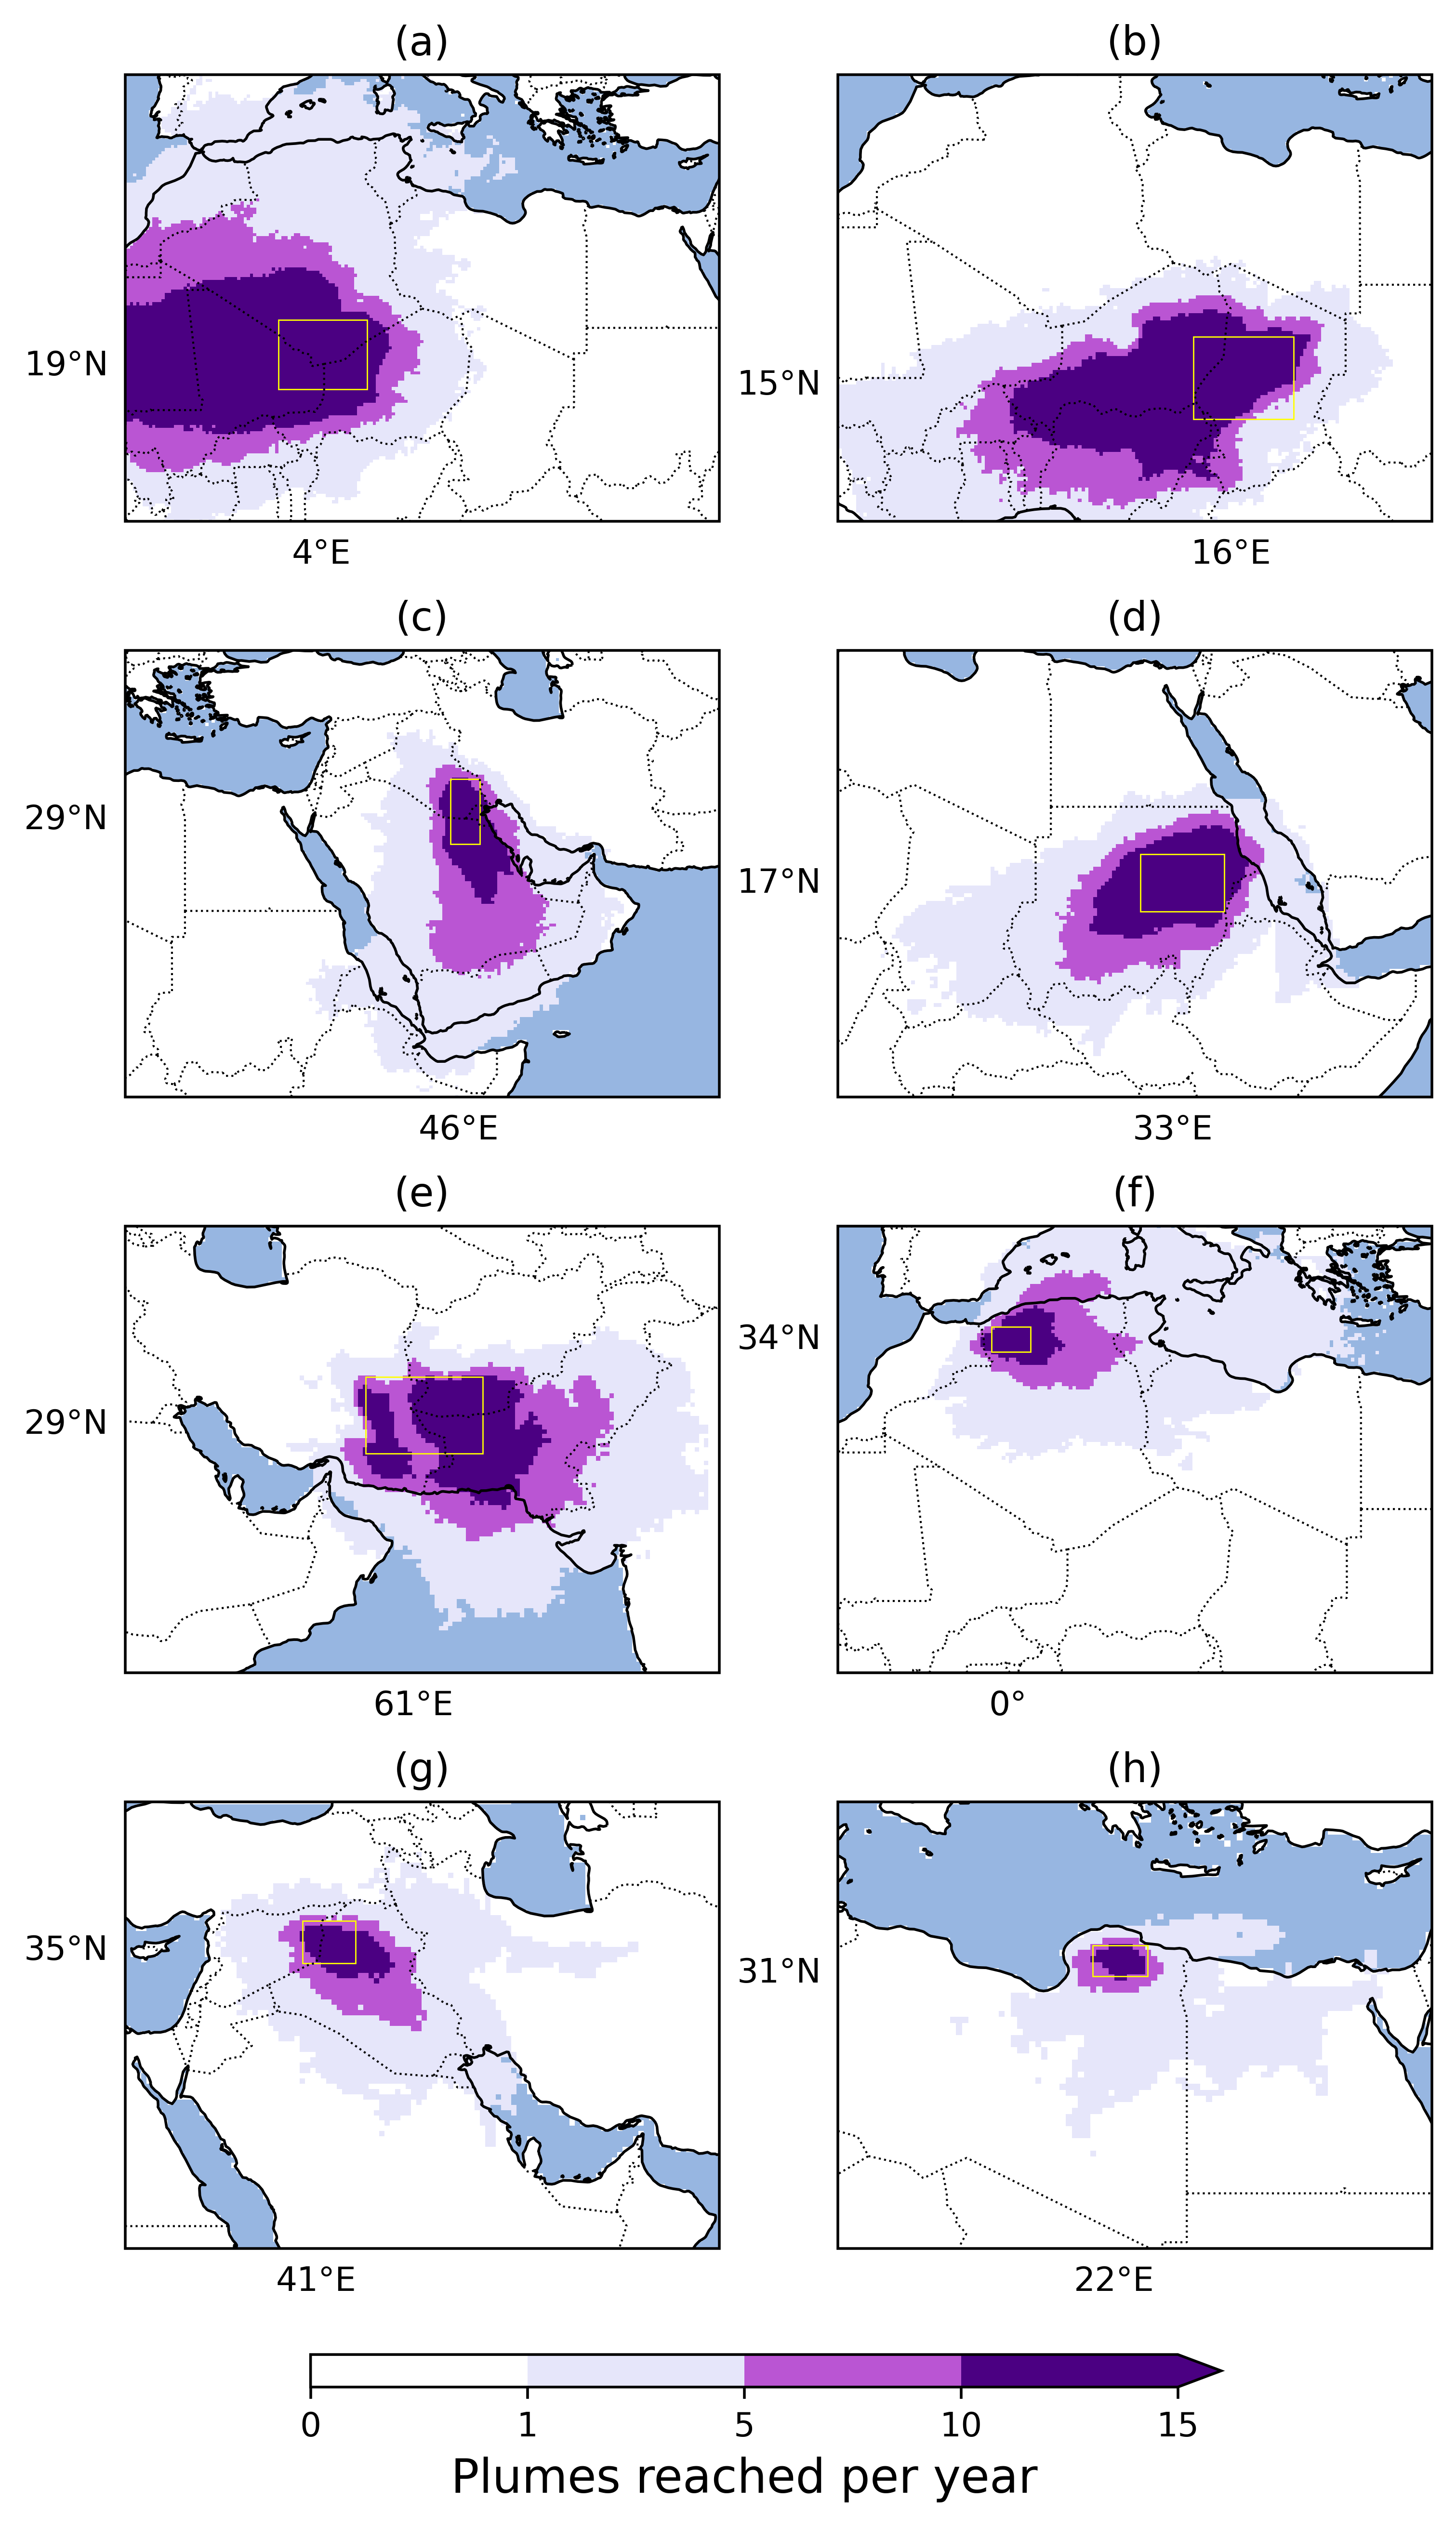

In [75]:
plt.figure(figsize=(7, 15), dpi=500)

# Subplot for talak
ax = plt.subplot(5, 2, 1, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(talak_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(talak_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(a)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(talak_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])

# Subplot for Bodel
ax = plt.subplot(5, 2, 2, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(bodele_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(bodele_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(b)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(bodele_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])

# Additional subplots for Shamal, Sistan, Sudan, Algeria, libya, and any other location.

# For example, Shamal subplot:
ax = plt.subplot(5, 2, 3, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(shamal_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(shamal_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(c)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(shamal_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])

# Continue with Sistan, Sudan, Algeria, and libya using the similar pattern.
# Subplot for Sudan
ax = plt.subplot(5, 2, 4, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(nubian_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(nubian_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(d)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(nubian_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])

# Subplot for Sistan
ax = plt.subplot(5, 2, 5, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(sitan_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(sistan_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(e)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(sistan_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])



# Subplot for Algeria
ax = plt.subplot(5, 2, 6, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(north_algeria_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(north_algeria_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(f)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(north_algeria_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])

# Syria
ax = plt.subplot(5, 2, 7, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)#, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.6)
ax.set_extent(syria_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.imshow(syria_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(g)")
#
min_lon, max_lon, min_lat, max_lat = extract_coordinates(syria_flag, lons, lats)
rect_width = max_lon - min_lon
rect_height = max_lat - min_lat
rectangle = mpatches.Rectangle((min_lon, min_lat), rect_width, rect_height,
                               transform=crs, 
                               edgecolor=cc, facecolor='none',lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])


# Subplot for libya
ax = plt.subplot(5, 2, 8, projection=crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.6)
ax.set_extent(libya_extent, crs)
gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.top_labels= gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
m = ax.imshow(libya_coverage, transform=crs, extent=bounds, cmap=cmap, norm=norm)
ax.set_title("(h)")
min_lon, max_lon, min_lat, max_lat = extract_coordinates(libya_flag, lons, lats)
rectangle = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                               transform=crs, edgecolor=cc, facecolor='none', lw=linw)
ax.add_patch(rectangle)
gl.xlocator = mticker.FixedLocator([(max_lon + min_lon )//2])
gl.ylocator = mticker.FixedLocator([(max_lat + min_lat )//2])




# Add a color bar and finalize layout
cax = plt.subplot(5, 2, 9)  # Adjust subplot for colorbar
cbar = plt.colorbar(m, shrink=0.8, extend="max", cax=cax, orientation='horizontal')
cbar.set_label('Plumes reached per year', size=14)
cax.set_position([0.235, 0.215, 0.54, 0.05])
cax.set_aspect(0.03)

# Save the figure if needed
plt.savefig("D:/figs/coverages_revised_ordered.pdf", bbox_inches="tight")